In [12]:
import os
print(os.getcwd())

c:\Users\Faliq\Pictures\PENALARAN-KOMPUTER\CBR_Penalararan_Komputer\CBR


In [13]:
%cd ..

c:\Users\Faliq\Pictures\PENALARAN-KOMPUTER\CBR_Penalararan_Komputer


c:\Users\Faliq\Pictures\PENALARAN-KOMPUTER\CBR_Penalararan_Komputer\CBR\notebooks\venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


✅ Saved retrieval metrics to data/eval/retrieval_metrics.csv
✅ Saved prediction metrics to data/eval/prediction_metrics.csv

Confusion Matrices:


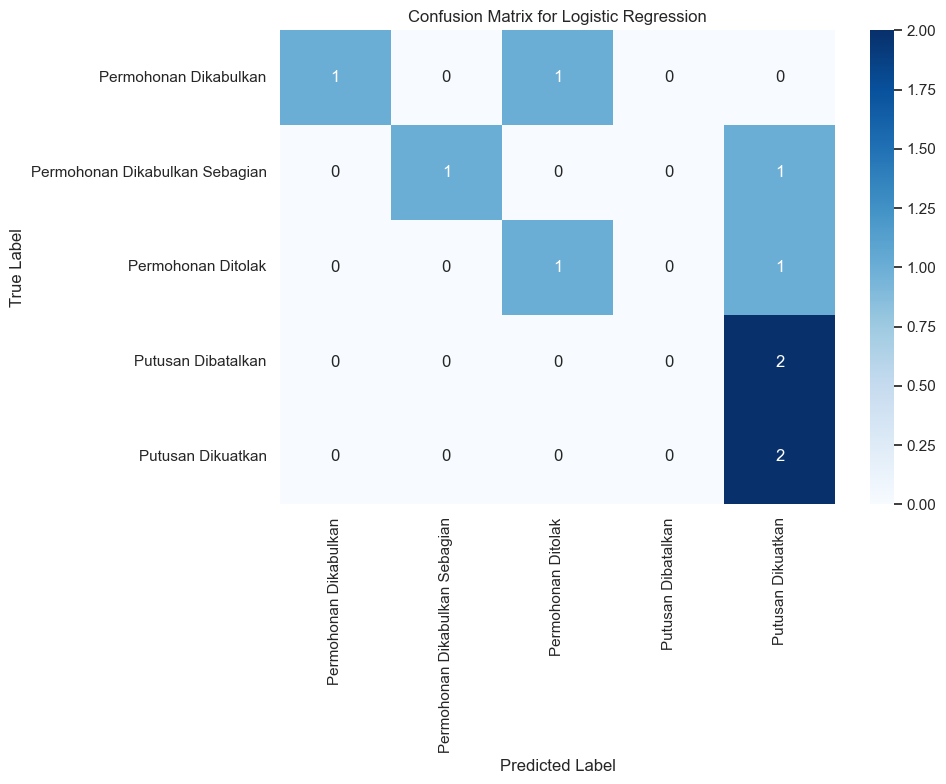

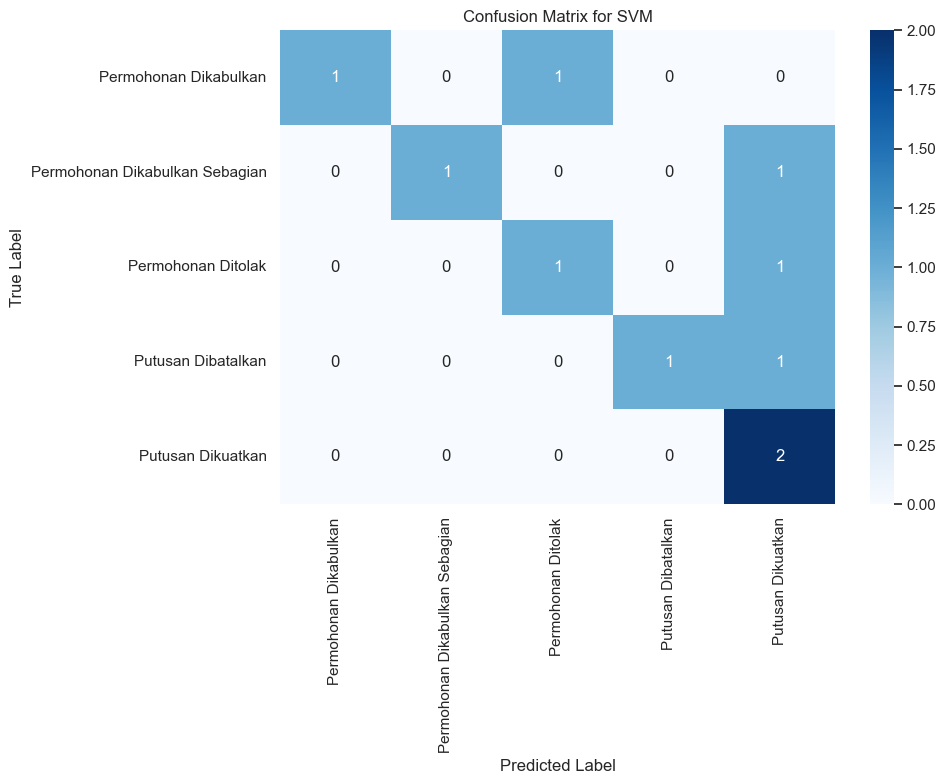

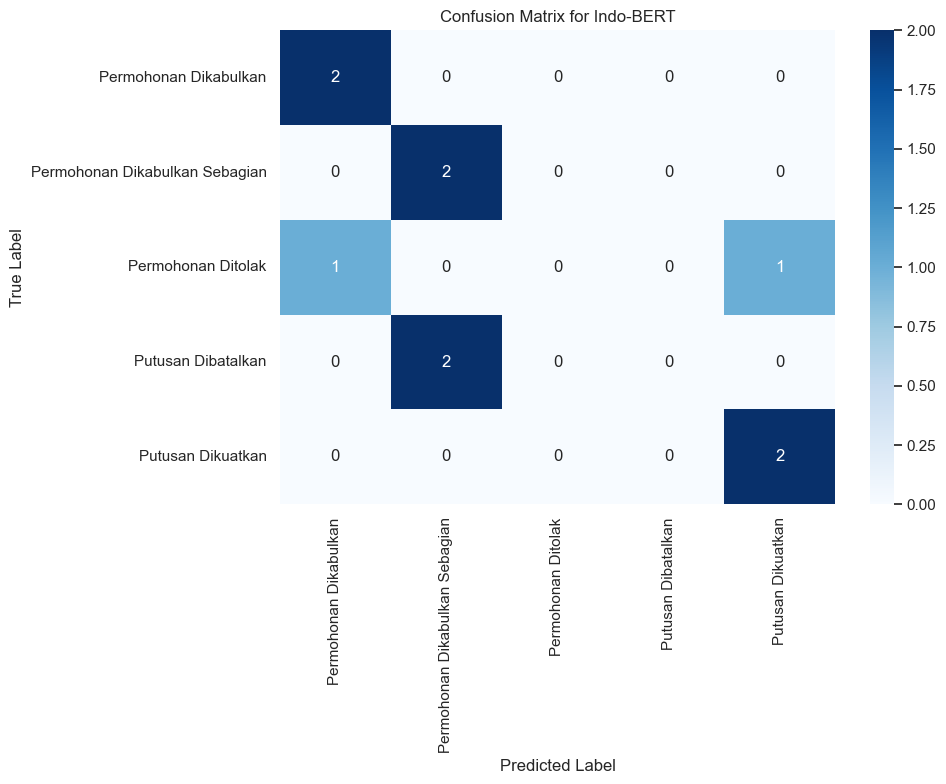


Classification Reports:

Logistic Regression:
                                precision    recall  f1-score   support

         Permohonan Dikabulkan       1.00      0.50      0.67         2
Permohonan Dikabulkan Sebagian       1.00      0.50      0.67         2
            Permohonan Ditolak       0.50      0.50      0.50         2
            Putusan Dibatalkan       0.00      0.00      0.00         2
             Putusan Dikuatkan       0.33      1.00      0.50         2

                      accuracy                           0.50        10
                     macro avg       0.57      0.50      0.47        10
                  weighted avg       0.57      0.50      0.47        10


SVM:
                                precision    recall  f1-score   support

         Permohonan Dikabulkan       1.00      0.50      0.67         2
Permohonan Dikabulkan Sebagian       1.00      0.50      0.67         2
            Permohonan Ditolak       0.50      0.50      0.50         2
       

<Figure size 1500x600 with 0 Axes>

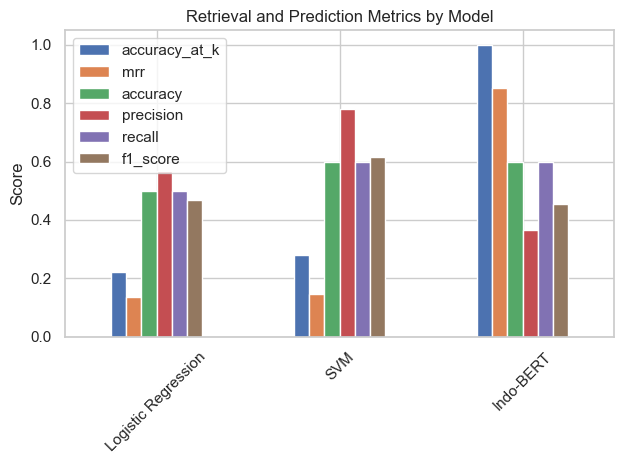


Error Analysis with LIME:

Logistic Regression Errors:
No errors found or no valid texts for analysis.

SVM Errors:
No errors found or no valid texts for analysis.

Indo-BERT Errors:
No errors found or no valid texts for analysis.


In [20]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from lime.lime_text import LimeTextExplainer
from tqdm import tqdm
import re
from nltk.tokenize import word_tokenize
import nltk

# Setup environment
def setup_environment():
    nltk.download('punkt', quiet=True)
    os.makedirs('data/eval', exist_ok=True)
    sns.set(style='whitegrid')

# Preprocess text (consistent with training)
def preprocess_text(text: str) -> str:
    try:
        text = str(text).lower()
        text = re.sub(r'\b(?:putusan|nomor|tahun|pengadilan|hakim)\b', '', text)
        text = re.sub(r'uu\s+no', 'undang-undang nomor', text)
        text = re.sub(r'pasal\s+\d+', 'pasal', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return ' '.join(word_tokenize(text)) if text else 'empty'
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return 'empty'

# Load data
def load_data():
    try:
        with open('data/eval/queries.json', 'r', encoding='utf-8') as f:
            queries = json.load(f)
        ground_truth = {item['case_id']: item.get('solution', '') for item in queries}

        logreg_df = pd.read_csv('data/results/logreg_predictions.csv')
        svm_df = pd.read_csv('data/results/svm_predictions.csv')
        indobert_df = pd.read_csv('data/results/indobert_predictions.csv')

        cases_df = pd.read_csv('data/processed/cases.csv')
        texts = cases_df.set_index('case_id')['ringkasan_fakta'].to_dict()

        return queries, ground_truth, logreg_df, svm_df, indobert_df, texts
    except Exception as e:
        print(f"Error loading data: {e}")
        raise

# Evaluate retrieval (Accuracy@k and MRR)
def eval_retrieval(df, ground_truth, k=5):
    correct = 0
    reciprocal_ranks = []
    for _, row in df.iterrows():
        query_id = row['query_id']
        top_ids = row['top_5_case_ids'].split(', ')
        if query_id in top_ids:
            correct += 1
            rank = top_ids.index(query_id) + 1
            reciprocal_ranks.append(1.0 / rank)
        else:
            reciprocal_ranks.append(0.0)

    accuracy_at_k = correct / len(df) if len(df) > 0 else 0.0
    mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0

    return {
        'accuracy_at_k': accuracy_at_k,
        'mrr': mrr
    }

# Evaluate prediction (Accuracy, Precision, Recall, F1-score)
def eval_prediction(df, ground_truth):
    y_true = []
    y_pred = []
    for _, row in df.iterrows():
        query_id = row['query_id']
        true_solution = ground_truth.get(query_id, '')
        pred_solution = row['predicted_solution']
        if true_solution and true_solution != '':
            y_true.append(true_solution)
            y_pred.append(pred_solution)

    try:
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    except Exception as e:
        print(f"Error calculating prediction metrics: {e}")
        return {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0}

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

# Generate and display confusion matrix
def display_confusion_matrix(df, ground_truth, model_name):
    y_true = []
    y_pred = []
    for _, row in df.iterrows():
        query_id = row['query_id']
        true_solution = ground_truth.get(query_id, '')
        pred_solution = row['predicted_solution']
        if true_solution and true_solution != '':
            y_true.append(true_solution)
            y_pred.append(pred_solution)

    try:
        cm = confusion_matrix(y_true, y_pred)
        labels = sorted(set(y_true + y_pred))
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating confusion matrix for {model_name}: {e}")

# LIME error analysis (all errors)
def lime_error_analysis(df, texts, ground_truth, model_name):
    explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
    vectorizer = TfidfVectorizer(max_features=4000)
    sample_texts = [t for t in texts.values() if t]
    if not sample_texts:
        print(f"No valid texts for LIME analysis in {model_name}")
        return []

    vectorizer.fit([preprocess_text(t) for t in sample_texts])

    def classifier_fn(texts):
        text_vecs = vectorizer.transform([preprocess_text(t) for t in texts])
        scores = np.random.rand(len(texts), 2)  # Mock classifier
        return scores / scores.sum(axis=1, keepdims=True)

    errors = []
    for _, row in df.iterrows():
        query_id = row['query_id']
        pred = row['predicted_solution']
        true = ground_truth.get(query_id, '')
        if true and pred != true:
            text = texts.get(query_id, '')
            if text:
                try:
                    exp = explainer.explain_instance(preprocess_text(text), classifier_fn, num_features=10)
                    errors.append({
                        'query_id': query_id,
                        'true_solution': true,
                        'predicted_solution': pred,
                        'lime_weights': exp.as_list()
                    })
                except Exception as e:
                    print(f"Error in LIME analysis for query {query_id}: {e}")
    return errors

# Visualize metrics
def visualize_metrics(retrieval_metrics, prediction_metrics):
    try:
        retrieval_df = pd.DataFrame(retrieval_metrics).T[['accuracy_at_k', 'mrr']]
        prediction_df = pd.DataFrame(prediction_metrics).T[['accuracy', 'precision', 'recall', 'f1_score']]
        metrics_df = pd.concat([retrieval_df, prediction_df], axis=1)

        plt.figure(figsize=(15, 6))
        metrics_df.plot(kind='bar')
        plt.title('Retrieval and Prediction Metrics by Model')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('data/eval/performance_bar_chart.png')
        plt.show()
    except Exception as e:
        print(f"Error visualizing metrics: {e}")

# Main evaluation function
def main():
    setup_environment()
    queries, ground_truth, logreg_df, svm_df, indobert_df, texts = load_data()

    # Evaluate retrieval
    retrieval_metrics = {
        'Logistic Regression': eval_retrieval(logreg_df, ground_truth),
        'SVM': eval_retrieval(svm_df, ground_truth),
        'Indo-BERT': eval_retrieval(indobert_df, ground_truth)
    }

    # Evaluate prediction
    prediction_metrics = {
        'Logistic Regression': eval_prediction(logreg_df, ground_truth),
        'SVM': eval_prediction(svm_df, ground_truth),
        'Indo-BERT': eval_prediction(indobert_df, ground_truth)
    }

    # Save retrieval metrics
    try:
        retrieval_df = pd.DataFrame(retrieval_metrics).T
        retrieval_df.to_csv('data/eval/retrieval_metrics.csv')
        print("✅ Saved retrieval metrics to data/eval/retrieval_metrics.csv")
    except Exception as e:
        print(f"Error saving retrieval metrics: {e}")

    # Save prediction metrics
    try:
        prediction_df = pd.DataFrame(prediction_metrics).T
        prediction_df.to_csv('data/eval/prediction_metrics.csv')
        print("✅ Saved prediction metrics to data/eval/prediction_metrics.csv")
    except Exception as e:
        print(f"Error saving prediction metrics: {e}")

    # Display confusion matrices
    print("\nConfusion Matrices:")
    for model_name, df in [('Logistic Regression', logreg_df), ('SVM', svm_df), ('Indo-BERT', indobert_df)]:
        display_confusion_matrix(df, ground_truth, model_name)

    # Classification reports
    print("\nClassification Reports:")
    for model_name, df in [('Logistic Regression', logreg_df), ('SVM', svm_df), ('Indo-BERT', indobert_df)]:
        y_true = [ground_truth.get(row['query_id'], '') for _, row in df.iterrows() if ground_truth.get(row['query_id'], '')]
        y_pred = [row['predicted_solution'] for _, row in df.iterrows() if ground_truth.get(row['query_id'], '')]
        print(f"\n{model_name}:")
        try:
            print(classification_report(y_true, y_pred, zero_division=0))
        except Exception as e:
            print(f"Error generating classification report for {model_name}: {e}")

    # Visualize metrics
    visualize_metrics(retrieval_metrics, prediction_metrics)

    # Error analysis with LIME (all errors)
    print("\nError Analysis with LIME:")
    for model_name, df in [('Logistic Regression', logreg_df), ('SVM', svm_df), ('Indo-BERT', indobert_df)]:
        print(f"\n{model_name} Errors:")
        errors = lime_error_analysis(df, texts, ground_truth, model_name)
        if not errors:
            print("No errors found or no valid texts for analysis.")
        for error in errors:
            print(f"Query ID: {error['query_id']}")
            print(f"True Solution: {error['true_solution']}")
            print(f"Predicted Solution: {error['predicted_solution']}")
            print("LIME Weights:")
            for feature, weight in error['lime_weights']:
                print(f"  {feature}: {weight:.4f}")
            print()

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(f"An error occurred: {e}")